<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">ARIMAX with Box Score Features</h4>
    <h5 style="font-weight: bold; font-size: 24px;">Test Set using Fixed Window Forecasting</h5>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**
  
**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

# Setup

[Return to top](#Models)

In [1]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [2]:
# load, filter (by time) and scale data
pts_scaled_df, pm_scaled_df, res_scaled_df, test_set_obs = utl.load_and_scale_data(
    input_data='../../data/processed/nba_team_matchups_rolling_box_scores_2022_2024_r10.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'], 
    training_season='2021-22',
    feature_prefixes=['ROLL_'],
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 692 games
Total number of games across sampled seasons: 3059 games


In [3]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181

In [4]:
pts_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,0.745,0.522,0.248,0.784,0.769,0.552,0.731,0.955,0.943,0.535,0.571,0.238,0.478,0.667,1.000,1.000,0.600,0.643,0.577,0.586,0.187,0.761,0.526,0.176,1.000,0.369,0.310,0.603,0.250,0.231,0.250,0.500,0.28,0.5,0.391,0.538,185
2021-10-23,0.000,0.000,0.624,0.000,0.077,0.372,0.000,0.553,0.574,0.438,1.000,0.333,0.826,0.000,0.385,0.238,0.657,0.554,0.096,0.017,0.350,0.000,0.421,0.588,0.364,0.323,0.177,0.837,0.312,0.615,0.583,0.083,0.28,0.3,0.348,0.615,198
2021-10-23,0.691,0.652,0.474,0.788,0.462,0.417,0.466,0.704,0.574,0.720,0.286,0.571,0.609,0.611,0.000,0.333,0.257,0.643,0.635,0.586,0.160,0.787,0.263,0.265,0.396,0.737,0.841,0.469,0.125,0.615,0.458,0.708,0.36,0.2,0.174,0.692,239
2021-10-23,0.727,0.826,0.662,0.860,0.538,0.193,0.772,0.352,0.410,0.315,0.571,0.095,0.348,1.000,0.231,0.143,0.029,0.643,0.250,0.069,0.106,0.244,0.368,0.559,0.317,0.645,0.885,0.268,0.000,0.231,0.083,0.208,0.20,0.0,0.348,1.000,232
2021-10-24,0.745,0.783,0.549,0.883,0.846,0.552,0.820,0.302,0.246,0.560,0.357,0.762,0.826,0.833,0.538,0.810,0.543,0.286,1.000,0.897,1.000,0.391,0.842,1.000,0.559,0.553,0.619,0.446,0.625,0.670,0.833,0.833,0.76,0.9,0.478,0.846,204


In [5]:
pm_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,PLUS_MINUS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,0.745,0.522,0.248,0.784,0.769,0.552,0.731,0.955,0.943,0.535,0.571,0.238,0.478,0.667,1.000,1.000,0.600,0.643,0.577,0.586,0.187,0.761,0.526,0.176,1.000,0.369,0.310,0.603,0.250,0.231,0.250,0.500,0.28,0.5,0.391,0.538,7.0
2021-10-23,0.000,0.000,0.624,0.000,0.077,0.372,0.000,0.553,0.574,0.438,1.000,0.333,0.826,0.000,0.385,0.238,0.657,0.554,0.096,0.017,0.350,0.000,0.421,0.588,0.364,0.323,0.177,0.837,0.312,0.615,0.583,0.083,0.28,0.3,0.348,0.615,-8.0
2021-10-23,0.691,0.652,0.474,0.788,0.462,0.417,0.466,0.704,0.574,0.720,0.286,0.571,0.609,0.611,0.000,0.333,0.257,0.643,0.635,0.586,0.160,0.787,0.263,0.265,0.396,0.737,0.841,0.469,0.125,0.615,0.458,0.708,0.36,0.2,0.174,0.692,29.0
2021-10-23,0.727,0.826,0.662,0.860,0.538,0.193,0.772,0.352,0.410,0.315,0.571,0.095,0.348,1.000,0.231,0.143,0.029,0.643,0.250,0.069,0.106,0.244,0.368,0.559,0.317,0.645,0.885,0.268,0.000,0.231,0.083,0.208,0.20,0.0,0.348,1.000,-10.0
2021-10-24,0.745,0.783,0.549,0.883,0.846,0.552,0.820,0.302,0.246,0.560,0.357,0.762,0.826,0.833,0.538,0.810,0.543,0.286,1.000,0.897,1.000,0.391,0.842,1.000,0.559,0.553,0.619,0.446,0.625,0.670,0.833,0.833,0.76,0.9,0.478,0.846,-10.0


In [6]:
res_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,GAME_RESULT
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,0.745,0.522,0.248,0.784,0.769,0.552,0.731,0.955,0.943,0.535,0.571,0.238,0.478,0.667,1.000,1.000,0.600,0.643,0.577,0.586,0.187,0.761,0.526,0.176,1.000,0.369,0.310,0.603,0.250,0.231,0.250,0.500,0.28,0.5,0.391,0.538,1
2021-10-23,0.000,0.000,0.624,0.000,0.077,0.372,0.000,0.553,0.574,0.438,1.000,0.333,0.826,0.000,0.385,0.238,0.657,0.554,0.096,0.017,0.350,0.000,0.421,0.588,0.364,0.323,0.177,0.837,0.312,0.615,0.583,0.083,0.28,0.3,0.348,0.615,0
2021-10-23,0.691,0.652,0.474,0.788,0.462,0.417,0.466,0.704,0.574,0.720,0.286,0.571,0.609,0.611,0.000,0.333,0.257,0.643,0.635,0.586,0.160,0.787,0.263,0.265,0.396,0.737,0.841,0.469,0.125,0.615,0.458,0.708,0.36,0.2,0.174,0.692,1
2021-10-23,0.727,0.826,0.662,0.860,0.538,0.193,0.772,0.352,0.410,0.315,0.571,0.095,0.348,1.000,0.231,0.143,0.029,0.643,0.250,0.069,0.106,0.244,0.368,0.559,0.317,0.645,0.885,0.268,0.000,0.231,0.083,0.208,0.20,0.0,0.348,1.000,0
2021-10-24,0.745,0.783,0.549,0.883,0.846,0.552,0.820,0.302,0.246,0.560,0.357,0.762,0.826,0.833,0.538,0.810,0.543,0.286,1.000,0.897,1.000,0.391,0.842,1.000,0.559,0.553,0.619,0.446,0.625,0.670,0.833,0.833,0.76,0.9,0.478,0.846,0


<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Models)

In [7]:
# split the data
X_train, X_test, y_train, y_test = pm_train_test_split(
    pts_scaled_df.drop('TOTAL_PTS', axis=1),
    pts_scaled_df['TOTAL_PTS'], 
    train_size=season_22_ngames+season_23_ngames
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2367, 36) (2367,) (692, 36) (692,)


In [8]:
start_time = time.time()

# fit models
model1 = pm.auto_arima(
    y=y_train, 
    X=X_train,
    start_p=1, max_p=20,
    start_q=1, max_q=5,
    max_d=3,   max_D=2,
    start_P=1, max_P=2,
    start_Q=1, max_Q=2,
    max_order=None,
    seasonal=False,
    stationary=False,
    information_criterion='aic',
    stepwise=True)

arimax_residuals = model1.resid()

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

Total time taken: 963.56 seconds


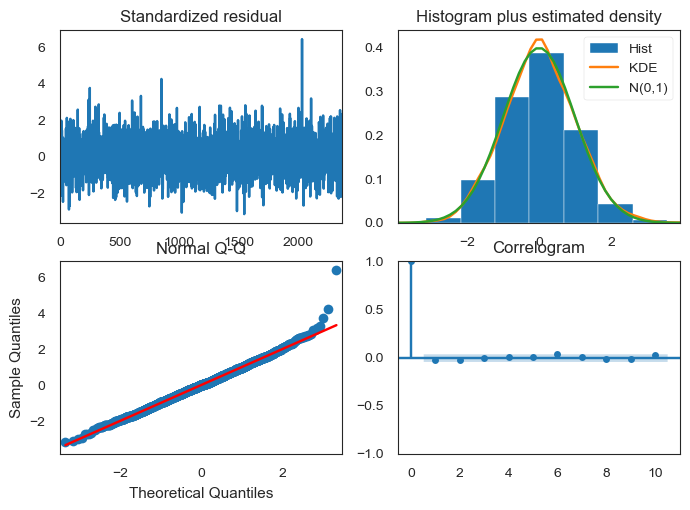

In [9]:
model1.plot_diagnostics();

In [10]:
# model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2367
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -10302.700
Date:                Tue, 09 Apr 2024   AIC                          20681.400
Time:                        23:25:17   BIC                          20900.620
Sample:                             0   HQIC                         20761.210
                               - 2367                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ROLL_HOME_PTS      9.394e+04     27.792   3379.908      0.000    9.39e+04     9.4e+04
ROLL_HOME_FGM     -7.854e+04    113.468   -692.145      0.000   -7.88e+04   -7.83e+04
ROLL_HOME_FGA        16.4525     33.989      0.484      0.628     -50.165      83.069
ROLL_HOME_FG_PCT     -6.7579     52.964     -0.128      0.898    -110.564      97.049
ROLL_HOME_FG3M    -2.216e+04     29.058   -762.641      0.000   -2.22e+04   -2.21e+04
ROLL_HOME_FG3A      -23.9977     17.874     -1.343      0.179     -59.031      11.036
ROLL_HOME_FG3_PCT   -39.5427     22.029     -1.795      0.073     -82.718       3.633
ROLL_HOME_FTM     -3.399e+04     41.170   -825.515      0.000   -3.41e+04   -3.39e+04
ROLL_HOME_FTA        13.8840     27.230      0.510      0.610     -39.487      67.255
ROLL_HOME_FT_PCT      3.3731     15.962      0.211      0.833     -27.911      34.657
ROLL_HOME_OREB     2.036e+04   3.13e+04      0.650      0.516   -4.11e+04    8.18e+04
ROLL_HOME_DREB     3.056e+04    4.7e+04      0.650      0.516   -6.16e+04    1.23e+05
ROLL_HOME_REB     -3.348e+04   5.15e+04     -0.650      0.516   -1.34e+05    6.74e+04
ROLL_HOME_AST         3.0893      3.972      0.778      0.437      -4.696      10.875
ROLL_HOME_STL       -14.0353      4.397     -3.192      0.001     -22.654      -5.417
ROLL_HOME_BLK         2.9136      3.852      0.756      0.449      -4.635      10.462
ROLL_HOME_TOV        14.3506      4.649      3.087      0.002       5.239      23.462
ROLL_HOME_PF         -1.8748      3.006     -0.624      0.533      -7.767       4.017
ROLL_AWAY_PTS      6.197e+04   3.34e+04      1.856      0.063   -3468.616    1.27e+05
ROLL_AWAY_FGM     -4.597e+04   2.48e+04     -1.852      0.064   -9.46e+04    2690.463
ROLL_AWAY_FGA       -61.4739     45.813     -1.342      0.180    -151.265      28.317
ROLL_AWAY_FG_PCT    -87.3572     46.744     -1.869      0.062    -178.974       4.260
ROLL_AWAY_FG3M    -2.265e+04   1.22e+04     -1.857      0.063   -4.66e+04    1260.515
ROLL_AWAY_FG3A       15.0250     25.504      0.589      0.556     -34.962      65.012
ROLL_AWAY_FG3_PCT    -1.8056     22.877     -0.079      0.937     -46.644      43.032
ROLL_AWAY_FTM      -2.58e+04   1.39e+04     -1.851      0.064   -5.31e+04    1512.752
ROLL_AWAY_FTA       -42.7037     25.357     -1.684      0.092     -92.403       6.995
ROLL_AWAY_FT_PCT    -28.0308     14.754     -1.900      0.057     -56.947       0.886
ROLL_AWAY_OREB     1295.4229   3.91e+04      0.033      0.974   -7.53e+04    7.79e+04
ROLL_AWAY_DREB     1480.6909   4.44e+04      0.033      0.973   -8.56e+04    8.86e+04
ROLL_AWAY_REB     -1961.8113   5.86e+04     -0.033      0.973   -1.17e+05    1.13e+05
ROLL_AWAY_AST         1.3757      5.563      0.247      0.805      -9.528      12.280
ROLL_AWAY_STL        -9.2480      4.454     -2.077      0.038     -17.977      -0.519
ROLL_AWAY_BLK         5.3614      3.870      1.385      0.166      -2.224      12.947
ROLL_AWAY_TOV        18.9573      6.133      3.091      0.0

In [11]:
# forecast mean (mu) and CI 
mu_forecast, mu_conf_int = model1.predict(
    n_periods=y_test.shape[0], 
    X=X_test,
    return_conf_int=True
)

# SMAPE
print("Symmetric Mean Absolute Percentage Error:", round(smape(y_test, mu_forecast), 2), "%")
# RMSE
print("Root Mean Squared Error:", round(mean_squared_error(y_test, mu_forecast, squared=False), 2))

Symmetric Mean Absolute Percentage Error: 6.54 %
Root Mean Squared Error: 18.85


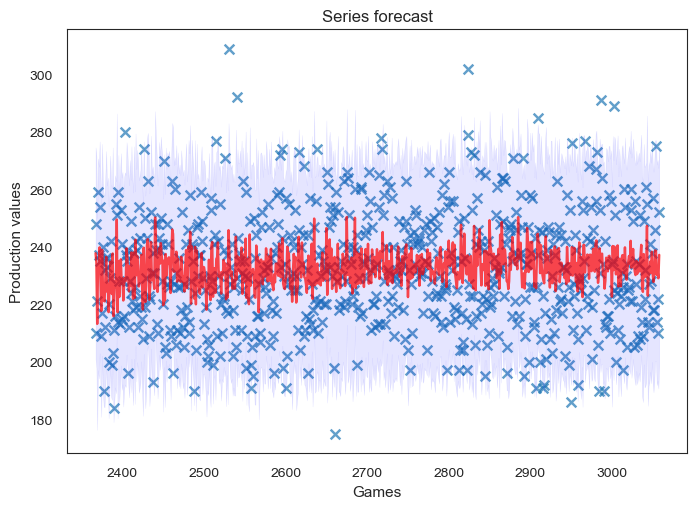

In [12]:
# plot forecast (blue=train, red=forecast)
x_axis = np.arange(pts_scaled_df['TOTAL_PTS'].shape[0])
#plt.plot(x_axis[:y_train.shape[0]], y_train, c='blue', alpha=0.7)
plt.plot(x_axis[y_train.shape[0]:], mu_forecast, c='red', alpha=0.7) # forecast
plt.scatter(x_axis[y_train.shape[0]:], y_test, alpha=0.7, marker='x') # test data
plt.fill_between(x_axis[-mu_forecast.shape[0]:], mu_conf_int[:, 0], mu_conf_int[:, 1], 
                 alpha=0.1, color='blue')
plt.title('Series forecast')
plt.xlabel('Games')
plt.ylabel('Production values')
plt.show();

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Models)

In [13]:
# split the data
X_train, X_test, y_train, y_test = pm_train_test_split(
    pm_scaled_df.drop('PLUS_MINUS', axis=1),
    pm_scaled_df['PLUS_MINUS'], 
    train_size=season_22_ngames+season_23_ngames
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2367, 36) (2367,) (692, 36) (692,)


In [14]:
start_time = time.time()

# fit models
model1 = pm.auto_arima(
    y=y_train, 
    X=X_train,
    start_p=1, max_p=20,
    start_q=1, max_q=5,
    max_d=3,   max_D=2,
    start_P=1, max_P=2,
    start_Q=1, max_Q=2,
    max_order=None,
    seasonal=False,
    stationary=False,
    information_criterion='aic',
    stepwise=True)

arimax_residuals = model1.resid()

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

Total time taken: 282.58 seconds


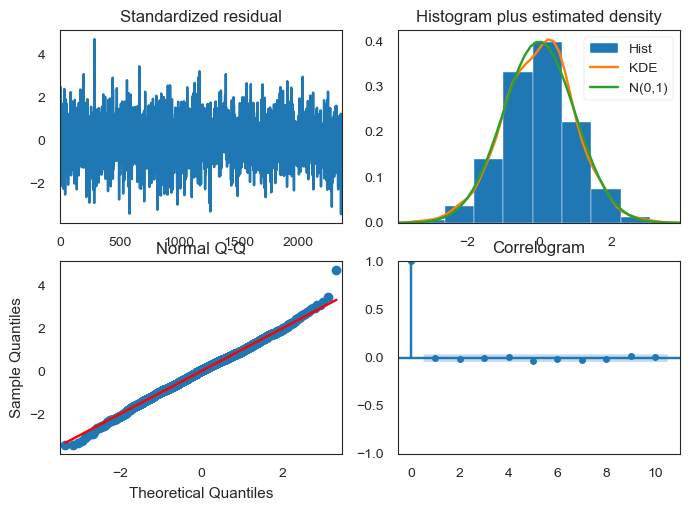

In [15]:
model1.plot_diagnostics();

In [16]:
# model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2367
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -9574.557
Date:                Tue, 09 Apr 2024   AIC                          19225.114
Time:                        23:30:01   BIC                          19444.350
Sample:                             0   HQIC                         19304.928
                               - 2367                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ROLL_HOME_PTS      2.012e+04   5.85e+04      0.344      0.731   -9.45e+04    1.35e+05
ROLL_HOME_FGM     -1.682e+04   4.89e+04     -0.344      0.731   -1.13e+05    7.91e+04
ROLL_HOME_FGA       -21.9947     25.976     -0.847      0.397     -72.908      28.918
ROLL_HOME_FG_PCT      0.7601     40.220      0.019      0.985     -78.069      79.589
ROLL_HOME_FG3M    -4791.5970   1.38e+04     -0.347      0.729   -3.19e+04    2.23e+04
ROLL_HOME_FG3A       26.5261     13.006      2.040      0.041       1.035      52.017
ROLL_HOME_FG3_PCT    31.5499     16.028      1.968      0.049       0.135      62.965
ROLL_HOME_FTM     -7249.0822   2.12e+04     -0.342      0.732   -4.87e+04    3.42e+04
ROLL_HOME_FTA       -31.7150     19.302     -1.643      0.100     -69.545       6.115
ROLL_HOME_FT_PCT    -17.4062     10.668     -1.632      0.103     -38.315       3.503
ROLL_HOME_OREB    -4997.3502   2.62e+04     -0.191      0.849   -5.63e+04    4.63e+04
ROLL_HOME_DREB    -7502.9361   3.92e+04     -0.191      0.848   -8.44e+04    6.94e+04
ROLL_HOME_REB      8229.7832    4.3e+04      0.191      0.848    -7.6e+04    9.25e+04
ROLL_HOME_AST         5.5327      2.991      1.850      0.064      -0.330      11.396
ROLL_HOME_STL        10.4509      3.345      3.124      0.002       3.894      17.007
ROLL_HOME_BLK        -0.9457      2.809     -0.337      0.736      -6.450       4.559
ROLL_HOME_TOV       -16.6005      3.469     -4.786      0.000     -23.399      -9.802
ROLL_HOME_PF         -0.3089      2.257     -0.137      0.891      -4.733       4.115
ROLL_AWAY_PTS     -6800.0977   5.82e+04     -0.117      0.907   -1.21e+05    1.07e+05
ROLL_AWAY_FGM      5053.0277   4.33e+04      0.117      0.907   -7.97e+04    8.98e+04
ROLL_AWAY_FGA        22.2907     33.635      0.663      0.508     -43.633      88.214
ROLL_AWAY_FG_PCT     -2.7980     34.172     -0.082      0.935     -69.773      64.177
ROLL_AWAY_FG3M     2451.9621   2.13e+04      0.115      0.908   -3.92e+04    4.41e+04
ROLL_AWAY_FG3A       12.7724     18.328      0.697      0.486     -23.149      48.694
ROLL_AWAY_FG3_PCT    23.4345     16.213      1.445      0.148      -8.342      55.211
ROLL_AWAY_FTM      2830.9521   2.43e+04      0.117      0.907   -4.47e+04    5.04e+04
ROLL_AWAY_FTA         2.9707     19.428      0.153      0.878     -35.107      41.048
ROLL_AWAY_FT_PCT    -12.8740     11.418     -1.128      0.260     -35.253       9.505
ROLL_AWAY_OREB     2.698e+04   3.27e+04      0.825      0.409   -3.71e+04    9.11e+04
ROLL_AWAY_DREB     3.069e+04   3.72e+04      0.825      0.409   -4.22e+04    1.04e+05
ROLL_AWAY_REB     -4.049e+04   4.91e+04     -0.825      0.409   -1.37e+05    5.57e+04
ROLL_AWAY_AST        -7.9778      3.810     -2.094      0.036     -15.445      -0.511
ROLL_AWAY_STL        -4.4961      2.907     -1.547      0.122     -10.194       1.202
ROLL_AWAY_BLK        -3.2186      2.697     -1.193      0.233      -8.505       2.068
ROLL_AWAY_TOV        25.1714      4.168      6.040      0.0

In [17]:
# forecast mean (mu) and CI 
mu_forecast, mu_conf_int = model1.predict(
    n_periods=y_test.shape[0], 
    X=X_test,
    return_conf_int=True
)

# SMAPE
print("Symmetric Mean Absolute Percentage Error:", round(smape(y_test, mu_forecast), 2), "%")
# RMSE
print("Root Mean Squared Error:", round(mean_squared_error(y_test, mu_forecast, squared=False), 2))

Symmetric Mean Absolute Percentage Error: 138.16 %
Root Mean Squared Error: 14.47


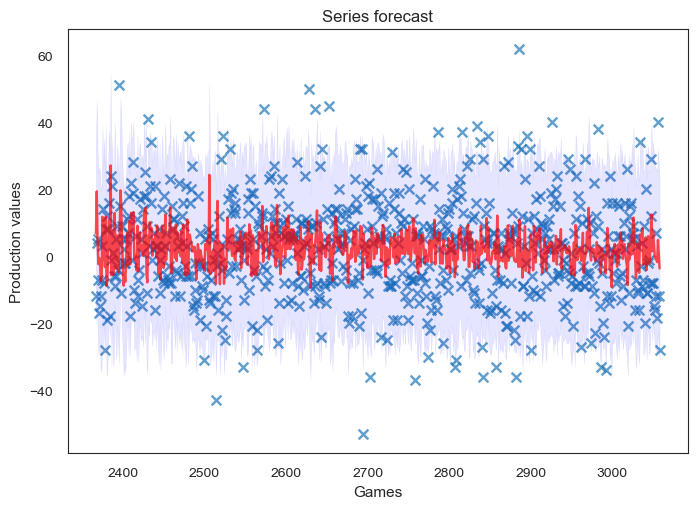

In [18]:
# plot forecast (blue=train, red=forecast)
x_axis = np.arange(pm_scaled_df['PLUS_MINUS'].shape[0])
#plt.plot(x_axis[:y_train.shape[0]], y_train, c='blue', alpha=0.7)
plt.plot(x_axis[y_train.shape[0]:], mu_forecast, c='red', alpha=0.7) # forecast
plt.scatter(x_axis[y_train.shape[0]:], y_test, alpha=0.7, marker='x') # test data
plt.fill_between(x_axis[-mu_forecast.shape[0]:], mu_conf_int[:, 0], mu_conf_int[:, 1], 
                 alpha=0.1, color='blue')
plt.title('Series forecast')
plt.xlabel('Games')
plt.ylabel('Production values')
plt.show();